In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt

Load Image of Apples 

In [2]:
ColorImage = glob.glob("apples/*.jpg") 
ColorImgs = [] 
for myFile in ColorImage:
    im = plt.imread(myFile)
    #change the range of each channel into [0,1]
    im = im/255
    ColorImgs.append(im) 

Load Mask of Apples 

In [3]:
mask = glob.glob("apples/*.png") 
masks = [] 
for myFile in mask:
    im = plt.imread(myFile) 
    #we only need 1-channel to display mask image
    im = im[:,:,0]
    masks.append(im) 


Generate a d by n training data matrix, where d is the dimension of training data and n is number of data.

In [4]:
Apple=[]
NonApple=[]
# use these number to calculate the prior of apple. P(apple) = nofapple /(nofapple + nofnonapple)
nofapple=0
nofnonapple=0

for i in range(len(ColorImgs)):
    rows,cols,channel = ColorImgs[i].shape
    for r in range(rows):
        for c in range(cols):
            # If equals to zero means this pxiel is black and it indicate that it belongs to nonapple part.
            if masks[i][r,c]==0.0:
                NonApple.append(ColorImgs[i][r,c,:])
                nofnonapple+=1
            # White pixels indicate locations where the corresponding photo is an apple
            else:
                Apple.append(ColorImgs[i][r,c,:])
                nofapple+=1
                
# change our data to be d*n data martix                
Apple=np.array(Apple).T
NonApple=np.array(NonApple).T


Helper function for calculate the gaussian distribution.

In [5]:
#the goal of this routine is to evaluate a Gaussian likelihood
def getGaussProb(x,mean,cov):
    """
    Returns the likelihood that each data point in data belongs to the Gaussian described by gaussMean and 
    gaussCov.
    Keyword arguments:
    data -- d by n matrix of data points. d is the number of dimensions and n is the number of data points.
    gaussMean -- d by 1 vector containing the mean parameter of the Gaussian distribution.
    gaussCov -- d by d matrix containing the covariance parameters of the Gaussian distribution.
    
    Returns: 
    like -- 1 by n vector contianing the likelihood that each data point in data belongs to the Gaussian 
    distribution defined by gaussMean and gaussCov.
    """
    nDim = x.shape[0] 
    mean = np.expand_dims(mean, axis=1)
    prob = np.exp(np.sum(-0.5*((x - mean).T @ np.linalg.pinv(cov)) * (x - mean).T, axis=1))
    prob = prob/((2.0*np.pi)**(nDim/2)*np.linalg.det(cov)**(1/2))
    return prob

**Calculate likelihood of pixels** 

It calculate the likelihood of each pixel by combining all the likelihood of different Gaussian models together using weighted sum.

In [6]:
def getMixGaussLike(data, mixGaussEst): 
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    Like -- n by 1 matrix
    
    """
    # initialize ikelihoods                                                                       
    Like = np.zeros((data.shape[1], ))                                                                               
    for i in range(mixGaussEst['k']):
        prob = getGaussProb(data, mixGaussEst['mean'][:,i], mixGaussEst['cov'][:,:,i]) 
        Like += mixGaussEst['weight'][i] * prob  
    return  Like                                                                                           

**Method for training a mixture of Gaussian model**

In [7]:
def fitMixGauss(data, k):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    nDims, nData = data.shape
    postHidden = np.zeros(shape=(k, nData))

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
    
    nIter = 50
    Like = getMixGaussLike(data, mixGaussEst)
    likesum = Like.sum() 
    print('Likelihood Iter 0 : {:4.3f}\n'.format(likesum))
    
    for cIter in range(nIter):
        #print('%d-th iteration'%(cIter))

        # ===================== =====================
        # Expectation step
        # ===================== =====================
        curCov = mixGaussEst['cov']                                                                                  
        curWeight = mixGaussEst['weight']                                                                            
        curMean = mixGaussEst['mean'] 
        
        #calculate posterior probability that
        #this data point came from each of the Gaussians
        for i in range(mixGaussEst['k']):
            postHidden[i] = curWeight[i]*getGaussProb(data,curMean[:,i],curCov[:,:,i])
        #postHidden is k by n
        postHidden = postHidden / np.sum(postHidden, axis=0)
        
    
        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            # Update weighting parameters mixGauss.weight based on the total
            # posterior probability associated with each Gaussian.
            curWeight[cGauss] = postHidden[cGauss,:].sum()/postHidden.sum()
            

            # Update mean parameters mixGauss.mean by weighted average
            # where weights are given by posterior probability associated with Gaussian.  
            curMean[:,cGauss] = (postHidden[cGauss,:].reshape(1,nData) @ data.T)/ postHidden[cGauss,:].sum()

            # Update covarance parameter based on weighted average of
            # square distance from update mean, where weights are given by
            # posterior probability associated with Gaussian
            meand = np.expand_dims(curMean[:,cGauss], axis=1)
            rikcov = postHidden[cGauss]*(data - meand) @ (data - meand).T
            curCov[:,:,cGauss] = rikcov / postHidden[cGauss,:].sum() 
            # calculate the log likelihood
        like = getMixGaussLike(data, mixGaussEst)
        likesum = like.sum()
        print('Likelihood After Iter {} : {:4.3f}\n'.format(cIter, likesum))
            
    return mixGaussEst

**Train a mixture of Gaussians model for apples and non-apples pixels**

In [8]:
%time
#define number of components to estimate
Hiddenv = 4

#fit mixture of Gaussians 
appleMixGaussEst = fitMixGauss(Apple,Hiddenv);
nonAppleMixGaussEst = fitMixGauss(NonApple,Hiddenv);

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.05 µs
Likelihood Iter 0 : 3072.941

Likelihood After Iter 0 : 1082111.270

Likelihood After Iter 1 : 1083003.869

Likelihood After Iter 2 : 1109220.251

Likelihood After Iter 3 : 2624140.399

Likelihood After Iter 4 : 7269833.796

Likelihood After Iter 5 : 7376111.170

Likelihood After Iter 6 : 7060842.065

Likelihood After Iter 7 : 6821346.969

Likelihood After Iter 8 : 6675117.112

Likelihood After Iter 9 : 6590354.883

Likelihood After Iter 10 : 6536008.703

Likelihood After Iter 11 : 6491059.036

Likelihood After Iter 12 : 6449668.271

Likelihood After Iter 13 : 6413404.127

Likelihood After Iter 14 : 6384044.118

Likelihood After Iter 15 : 6361506.557

Likelihood After Iter 16 : 6343804.191

Likelihood After Iter 17 : 6329130.020

Likelihood After Iter 18 : 6317641.584

Likelihood After Iter 19 : 6309846.892

Likelihood After Iter 20 : 6306733.660

Likelihood After Iter 21 : 6309728.923

Likelihood After Iter 22 : 6320902.7

An interesting fact is that our data model does not converge with give iteration.

Guess: 
1. The more iteration we loop we will get more accurate data.
2. The hidden variable which is number of gaussian in our model will also affect the performance of    our           training example.
3. Influence by large covariance.
       

Calculate each pixel’s posterior probability of being “apple.” 

In [9]:
def CalculatePosterior(Imgs,priorApple):
    """
    Returns:
    A list of posterior corresponding to each picture of apple.
    """
    # since we calculate the posterior of multiple images at the same time, 
    #we need to create a arry to store them all.
    posteriorApple = []
    for i in range(len(Imgs)):
        img = Imgs[i]
        rows, cols, cha = img.shape
        img = np.double(img)
        #change the img into n*d dataset
        img = np.reshape(img, [rows*cols,cha])
        img = img.T
        #to keep consistent we use d*n matrix to calculate the likelihood
        likApple = getMixGaussLike(img,appleMixGaussEst)
        liknonApple = getMixGaussLike(img,nonAppleMixGaussEst)
        posterior = (likApple*priorApple)/(likApple*priorApple+liknonApple*(1 - priorApple))
        posterior = np.reshape(posterior, (rows, cols))
        posteriorApple += [posterior]
    return posteriorApple

In [10]:
def calculatePrior(napple,nnonapple):
    """
    Returns:
    The prior of our apples.
    """
    priorApple = napple/(napple + nnonapple)
    return priorApple

In [11]:
def calculateBinary(images, posteriorApples):
    """
    Returns: 
    The binary result of our images with given posterior.
    """
    binaryApples = []
    for i in range(len(images)):
        rows, cols, cha = images[i].shape
        posteriorApple = posteriorApples[i]  
        binaryApple = np.zeros((rows,cols))
        for r in range(rows):
            for c in range(cols):
                if posteriorApple[r][c] >= 0.5:
                    binaryApple[r][c] = 1
                if posteriorApple[r][c] < 0.5:
                    binaryApple[r][c] = 0
        binaryApples += [binaryApple]
    return binaryApples 

In [12]:
def CalculateRoc(targets, outputs): 
    """
    Using Roc curve to quantify and report our results of test images with a ground-truth mask.
    True Positives (TP)
    True Negatives (TN)
    False Positives (FP)
    False Negatives (FN)
    True Positive Rate (TPR)
    False Positive Rate (FPR)
    
    From the http://people.cs.bris.ac.uk/~flach/papers/ROCanalysis.pdf we know, 
    we often interested the relation between TPR and FPR
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)

    Returns: 
    The FPR,TPR which is used for plot our ROC curve.
    
    """
    r,c = targets.shape
    nthreshold = 500
    threshold =  np.linspace(0,1,nthreshold)
    
    TP = np.zeros(nthreshold)
    FP = np.zeros(nthreshold)
    TPR = np.zeros(nthreshold)
    FPR = np.zeros(nthreshold)
   
    for i in range(nthreshold):
        temp = outputs > threshold[i]
        
        TP = (targets * temp).sum()
        FP = temp.sum() - TP
        
        TPR[i] = TP/targets.sum()
        FPR[i] = FP/(r*c - targets.sum())
        
    #This method need lots of memory and time to compute, instead we find anohter efficient way.
    #for i in range(nthreshold): 
        #for r in range(rows):
            #for c in range(cols):
                #if (targets[r][c] == 1) && (outputs[r][c] == 1):
                   # TP[i] += 1
                #else if (targets[r][c] == 1) && (outputs[r][c] == 0):
                    #FP[i] += 1
                #else if (targets[r][c] == 0) && (outputs[r][c] == 1):
                    #FN[i] += 1 
                #else if (targets[r][c] == 0) && (outputs[r][c] == 0):
                    #TN[i] += 1
    #TPR = TP/(TP+FN)
    #FPR = FP/(FP+TN)
    
    
    return FPR,TPR

In [13]:
# get the prior of apple
priorApple = calculatePrior(nofapple,nofnonapple)
# get the posterior of apple 
posteriorApple = CalculatePosterior(ColorImgs,priorApple)
#get the binary result of apple
binaryApples = calculateBinary(ColorImgs,posteriorApple)


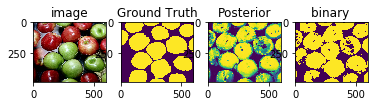

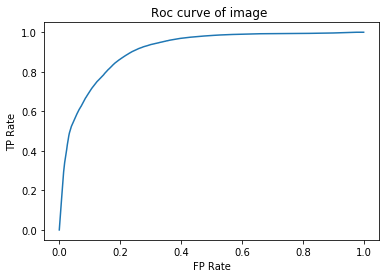

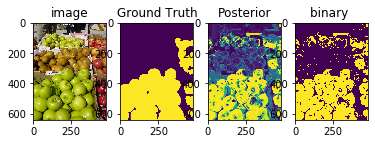

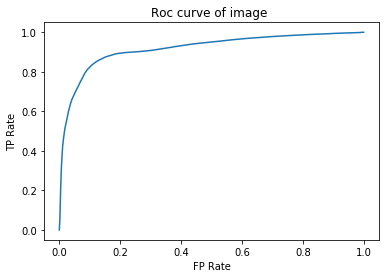

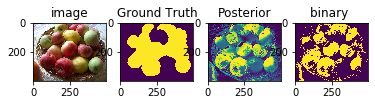

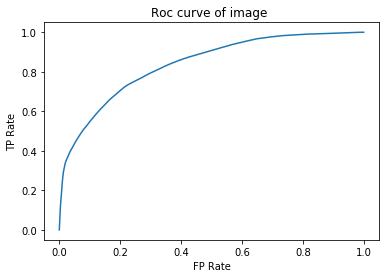

In [14]:
for i in range(len(posteriorApple)):
    # Set up plots
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
    # show the image
    ax1.imshow(ColorImgs[i])
    ax1.set_title('image')
    # Show the ground truth mask
    ax2.imshow(masks[i])
    ax2.set_title('Ground Truth')
    # Show our prediction
    ax3.imshow(posteriorApple[i])
    ax3.set_title('Posterior')
    # Show binary result
    ax4.imshow(binaryApples[i])
    ax4.set_title('binary ')
    # show roc curve
    #get roc curve 
    FPR,TPR = CalculateRoc(masks[i],posteriorApple[i])
    f, (ax5) = plt.subplots()
    ax5.set_title('Roc curve of image ')
    plt.plot(FPR,TPR)
    ax5.set_xlabel('FP Rate')
    ax5.set_ylabel('TP Rate')

Load test images of apples

In [15]:
testColorImage = glob.glob("testApples/*.jpg") 
testColorImages = [] 
for myFile in testColorImage:     
    im = plt.imread(myFile)
    #change the range of each pixel into [0,1]
    im = im/255
    testColorImages.append(im)

Load test mask image of apples

In [16]:
testMask = glob.glob("testapples/*.png") 
testMasks = [] 
for myFile in testMask:
    im = plt.imread(myFile) 
    #we only need 1-channel to display mask image
    im = im[:,:,0] 
    testMasks.append(im)

Using the prior obtained from training data and calculate the posteriror and binary classification.

In [17]:
# get the prior of test apple
priorApple = calculatePrior(nofapple,nofnonapple)
#get the posterior of test apple 
posteriorApple2 = CalculatePosterior(testColorImages,priorApple)
#get the binary result of test apple
binaryApples2 = calculateBinary(testColorImages,posteriorApple2)


Plot each figure correspoding to the test data.

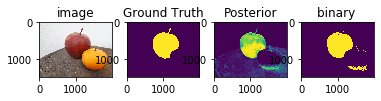

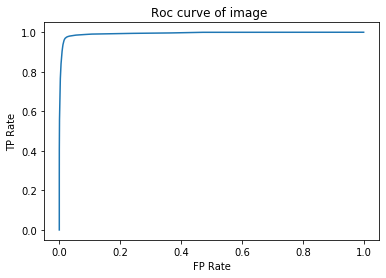

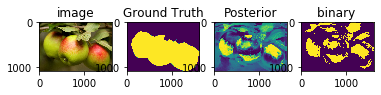

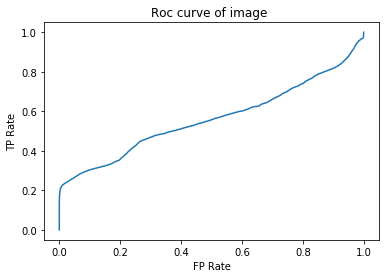

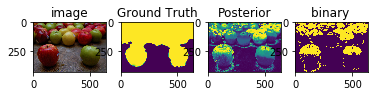

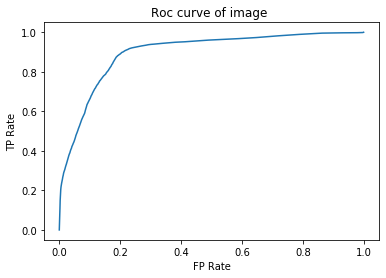

In [18]:
for i in range(len(posteriorApple2)):
    # Set up plots
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
    # show the image
    ax1.imshow(testColorImages[i])
    ax1.set_title('image')
    # Show the ground truth mask
    ax2.imshow(testMasks[i])
    ax2.set_title('Ground Truth')
    # Show our prediction
    ax3.imshow(posteriorApple2[i])
    ax3.set_title('Posterior')
    # Show binary result
    ax4.imshow(binaryApples2[i])
    ax4.set_title('binary ')
    # show roc curve
  
    FPR,TPR = CalculateRoc(testMasks[i],posteriorApple2[i])
    f, (ax5) = plt.subplots()
    ax5.set_title('Roc curve of image ')
    plt.plot(FPR,TPR)
    ax5.set_xlabel('FP Rate')
    ax5.set_ylabel('TP Rate')


Load validate data, more apples data to verify our model.

In [19]:
ColorImage = glob.glob("moreApples/*.jpg") 
moreColorImages = []
for myFile in ColorImage:     
    im = plt.imread(myFile)
    #change the range of each channel into [0,1]
    im = im/255
    moreColorImages.append(im)

Load ground truth for our validata data. Creating those pictures by using photoshop.

In [20]:
MaskImage = glob.glob("moreApples/*.png") 
moreMasks = [] 
for myFile in MaskImage:
    im = plt.imread(myFile) 
    #we only need 1-channel to display mask image
    im = im[:,:,0]
    moreMasks.append(im) 

Using the prior obtained from training data and calculate the posteriror and binary classification.

In [21]:
# get the prior of apple
priorApple = calculatePrior(nofapple,nofnonapple)
# get the posterior of validate apple data
posteriorApple3 = CalculatePosterior(moreColorImages,priorApple)
#get the binary result of validate apple data
binaryApples3 = calculateBinary(moreColorImages,posteriorApple3)

Plot each figure correspoding to the validate data.

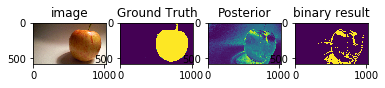

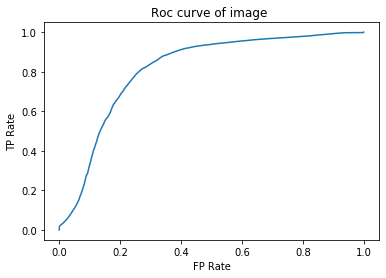

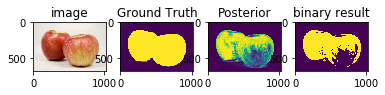

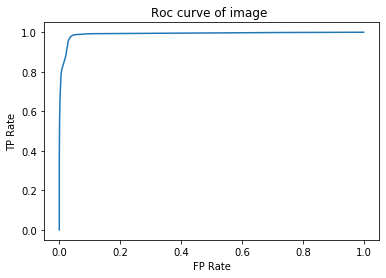

In [22]:
for i in range(len(posteriorApple3)):
    # Set up plots
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    # show the image
    ax1.imshow(moreColorImages[i])
    ax1.set_title('image')
    # Show the ground truth mask
    ax2.imshow(moreMasks[i])
    ax2.set_title('Ground Truth')
    # Show our prediction
    ax3.imshow(posteriorApple3[i])
    ax3.set_title('Posterior')
    # Show binary result
    ax4.imshow(binaryApples3[i])
    ax4.set_title('binary result')
    # show roc curve
    FPR,TPR = CalculateRoc(moreMasks[i],posteriorApple3[i])
    f, (ax5) = plt.subplots()
    plt.plot(FPR,TPR)
    ax5.set_title('Roc curve of image ')
    ax5.set_xlabel('FP Rate')
    ax5.set_ylabel('TP Rate')

**Why we use three separate sets of files**

Training Set: this data set is used to adjust the weights of model.
A training dataset is a dataset of examples used for learning, that is to fit the parameters of our model.

Test Set: A test set is used only to assess the performance of our model.
A test dataset is a dataset that is independent of the training dataset, but that follows the same probability distribution as the training dataset. 

Validation set: A validation dataset is used to tune the hyperparameters(ie. hidden variable)of our classification model.We can use validation dataset to avoid overfitting.
This data can provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters.
We can use validation set to verify the accuracy of our model but indirectly.  